# RNN Classifier con PyTorch Lightning
## Trabajo Computacional 2

Este notebook implementa un clasificador RNN para predecir el origen de nombres utilizando PyTorch Lightning.

### Objetivos
- Implementar un modelo RNN, LSTM y GRU para la tarea de clasificación usando PyTorch Lightning
- Modularizar el código en componentes reutilizables:
  - `model.py`: Definición del modelo RNN
  - `datamodule.py`: Manejo de datos y preprocessing
  - `training.py`: Loop de entrenamiento y evaluación

## Instalación y configuración

Primero instalamos las dependencias necesarias e importamos las bibliotecas.

In [1]:
# Instalar PyTorch Lightning si no está instalado
# !pip install lightning

In [2]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import time

# Importar módulos personalizados
from utils.model import RNNClassifier, find_latest_checkpoint
from utils.datamodule import RNNDataset, RNNDataModule, n_letters
from utils.eval import evaluate_model, plot_confusion_matrix, predict_name_origin

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
torch.manual_seed(47)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA


## Preparación de datos

Descargamos y preparamos los datos de nombres si no están disponibles.

In [3]:
# Descargar datos si no existen
if not os.path.exists('./data'):
    print("Descargando datos...")
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip
    !rm data.zip
    print("Datos descargados exitosamente!")
else:
    print("Los datos ya están disponibles.")

Los datos ya están disponibles.


### Distribución de datos y balanceo

Al cargar e inspeccionar los datos, estos se encontraban muy desbalanceados. Para poder definir las épocas adecuadamente se hizo un sobremuestreo de las clases con menos datos y con esto tener una distribución más equitativa de los datos

In [4]:
# Cargamos el dataset
dataset = RNNDataset(data_path="./data/names/", balanced=True, verbose=True)

Cargando datos desde ./data/names/...


Polish: 139 ejemplos
Greek: 203 ejemplos
Chinese: 268 ejemplos
Scottish: 100 ejemplos
Italian: 709 ejemplos
German: 724 ejemplos
Dutch: 297 ejemplos
Arabic: 2000 ejemplos
Portuguese: 74 ejemplos
English: 3668 ejemplos
Russian: 9408 ejemplos
French: 277 ejemplos
Czech: 519 ejemplos
Japanese: 991 ejemplos
Spanish: 298 ejemplos
Korean: 94 ejemplos
Vietnamese: 73 ejemplos
Irish: 232 ejemplos

Balanceando dataset...
Polish - nuevo tamaño: 9313
Greek - nuevo tamaño: 9338
Chinese - nuevo tamaño: 9380
Scottish - nuevo tamaño: 9400
Italian - nuevo tamaño: 9217
German - nuevo tamaño: 8688
Dutch - nuevo tamaño: 9207
Arabic - nuevo tamaño: 8000
Portuguese - nuevo tamaño: 9398
English - nuevo tamaño: 7336
Russian - tamaño original: 9408
French - nuevo tamaño: 9141
Czech - nuevo tamaño: 9342
Japanese - nuevo tamaño: 8919
Spanish - nuevo tamaño: 9238
Korean - nuevo tamaño: 9400
Vietnamese - nuevo tamaño: 9344
Irish - nuevo tamaño: 9280


In [5]:
categories = dataset.categories

print(f"Número total de categorías: {len(categories)}")
print(f"Categorías disponibles: {categories}")

print(f"\nEjemplos de entrenamiento:")
for i in range(5):
    category, line, category_tensor, line_tensor = dataset.get_random_sample()
    print(f"category = {category} / line = {line}")


Número total de categorías: 18
Categorías disponibles: ['Polish', 'Greek', 'Chinese', 'Scottish', 'Italian', 'German', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Russian', 'French', 'Czech', 'Japanese', 'Spanish', 'Korean', 'Vietnamese', 'Irish']

Ejemplos de entrenamiento:
category = Japanese / line = Kawasaki
category = Polish / line = Sokolsky
category = French / line = Travers
category = Czech / line = Navara
category = Irish / line = O'Donnell


## Entrenamiento del modelo

Ahora entrenamos el modelo RNN usando PyTorch Lightning. El entrenamiento esta dentro de un script de python separado para poder ejecutarlo fuera del kernel interactivo del presente notebook

In [ ]:
import subprocess
import sys

# Ejecuta el script de entrenamiento usando subprocess
script_path = "rnn-training.py"

# Verificar que el script existe
if not os.path.exists(script_path):
    print(f"Error: No se encontró el archivo {script_path}")
    exit(1)

print("Iniciando entrenamiento del modelo RNN...")

try:
    # Ejecutar el script con subprocess
    process = subprocess.Popen(
        [sys.executable, script_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1
    )
    
    # Mostrar la salida en tiempo real
    for line in process.stdout:
        print(line.rstrip())
    
    # Esperar a que termine el proceso
    process.wait()
    
    if process.returncode == 0:
        print("Entrenamiento completado exitosamente!")
    else:
        print("\n" + "=" * 60)
        print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
except Exception as e:
    print(f"Error al ejecutar el script: {str(e)}")

Iniciando entrenamiento del modelo RNN...


PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA
Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.00125
  n_epochs: 100
  batch_size: 32
  num_workers: 40
Probando modelo base: rnn
Creando instancia de modelo RNN (rnn)...
Modelo creado exitosamente!
Arquitectura del modelo:
  - Input size: 57 (caracteres)
  - Hidden size: 128
  - Output size: 18 (categorías)
  - Learning rate: 0.00125
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
No se encontró checkpoint en None, entrenando desde cero.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA
Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.00125
  n_epochs: 100
  batch_size: 32
  num_workers: 40
Probando modelo base: rnn
Creando instancia de modelo RNN (rnn)...
PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Devi

## Evaluación del modelo

Evaluamos el modelo entrenado y visualizamos los resultados.

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Evaluando el modelo...

Evaluando modelo: RNN


/home/eaguayo/.local/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/rnn-classifier/rnn/eval exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9481000304222107     │
└───────────────────────────┴───────────────────────────┘

/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/eval.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  def plot_confusion_matrix(cm, categories, title='Confusion Matrix'):
/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/eval.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


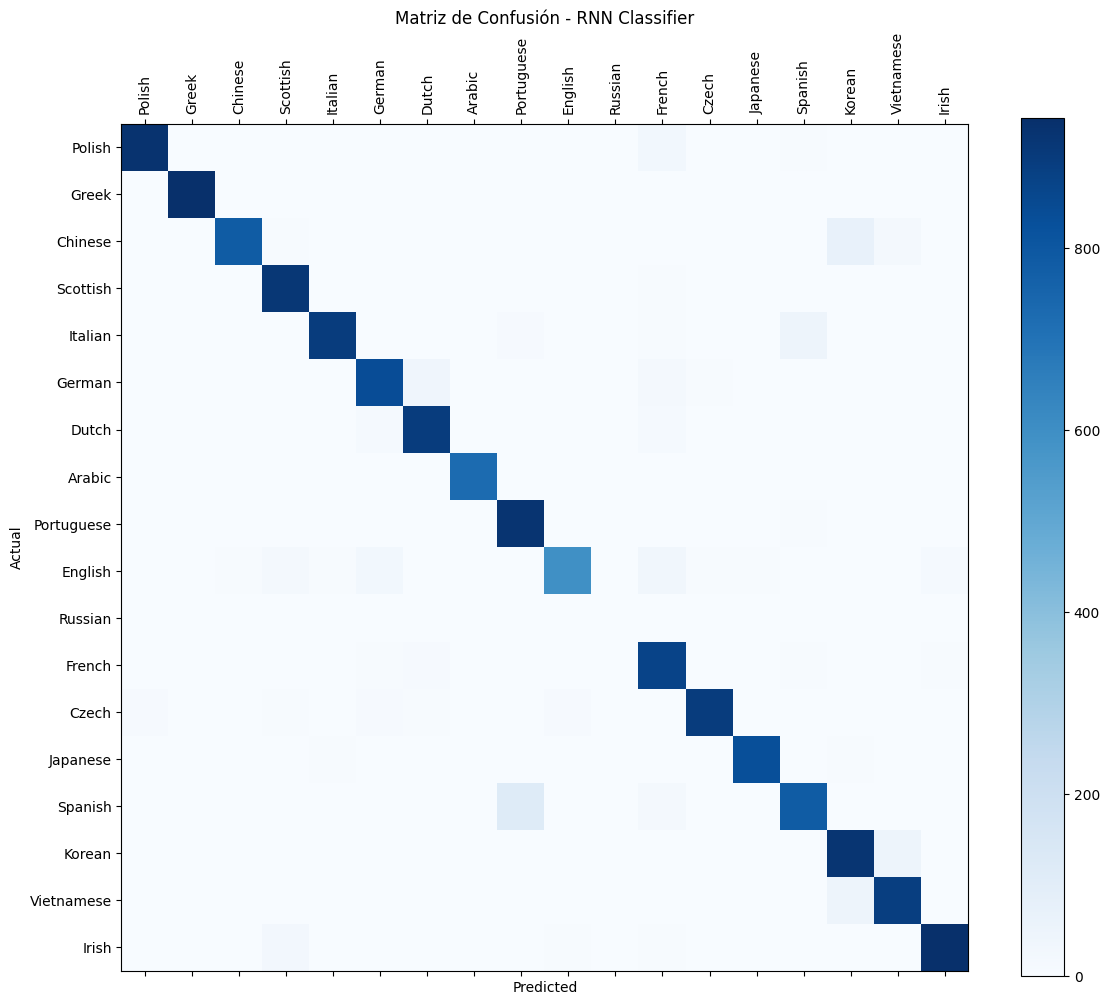

In [ ]:
# Evaluar el modelo
print("Evaluando el modelo...")
base_models = ["rnn", "lstm", "gru"]
# base_models = ["rnn"]  # Para debug, solo evaluamos el modelo RNN
trainers = {}
models = {}

for base_model in base_models:
    print(f"\nEvaluando modelo: {base_model.upper()}")

    # Cargar el mejor checkpoint basado en validación
    # best_checkpoint = f"./checkpoints/{base_model}/epoch=75-step=73188.ckpt"
    best_checkpoint = find_latest_checkpoint(base_model)
    if not best_checkpoint:
        print(f"No se encontró checkpoint para el modelo {base_model}. Saltando evaluación.")
        continue
    models[base_model] = RNNClassifier.load_from_checkpoint(best_checkpoint)

    logger = CSVLogger(save_dir="logs/rnn-classifier", name=f"{base_model}", version="eval")

    trainers[base_model] = pl.Trainer(
        max_epochs=10,
        callbacks=[],
        accelerator="auto",  # Uses GPUs or TPUs if available
        devices="auto",  # Uses all available GPUs/TPUs if applicable
        logger=logger,
        deterministic=False,
        log_every_n_steps=10,
    )

    data_module = RNNDataModule(
        data_path="./data/names/", batch_size=32, num_workers=40
    )

    trainers[base_model].test(models[base_model], datamodule=data_module)
    # accuracy, confusion_matrix, categories = evaluate_model(model, data_module, n_samples=1000)

    cm = models[base_model].get_confusion_matrix()
    if cm is None:
        print(f"No se pudo obtener la matriz de confusión para el modelo {base_model}.")
        continue

    # # Visualizar matriz de confusión
    plot_confusion_matrix(cm, categories, 'Matriz de Confusión - RNN Classifier')

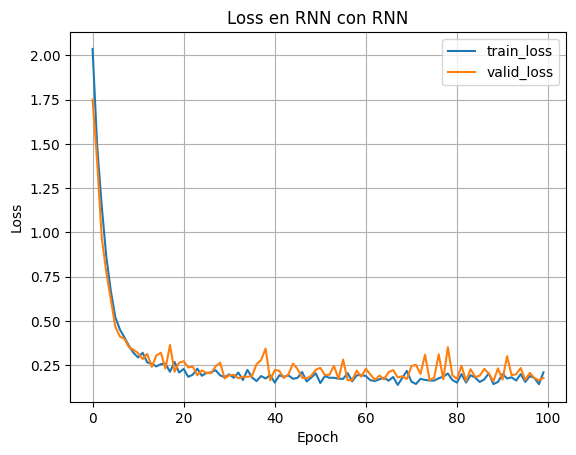

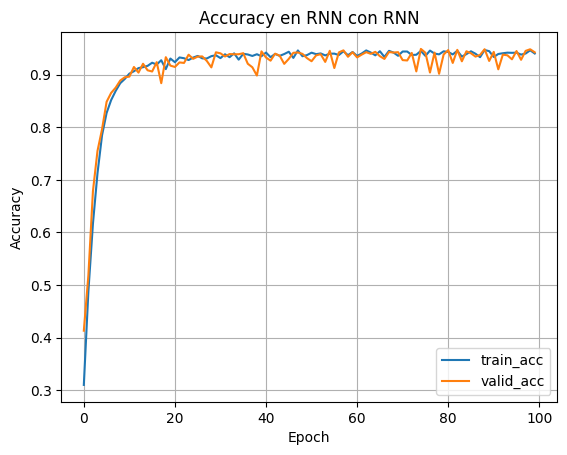

In [ ]:
import pandas as pd

for base_model in base_models:
    # metrics = pd.read_csv(f"{trainers[base_model].logger.log_dir}/metrics.csv")

    # Concatenate metric files from all versions for the given model
    log_dir = f"logs/rnn-classifier/{base_model}"
    all_metrics = []

    if not os.path.exists(log_dir):
        print(f"No se encontró el directorio de logs para el modelo {base_model}. Saltando visualización.")
        continue
    for version in os.listdir(log_dir):
        if not version.startswith("version_"):
            continue
        version_dir = os.path.join(log_dir, version)
        metrics_file = os.path.join(version_dir, "metrics.csv")
        if os.path.exists(metrics_file):
            df = pd.read_csv(metrics_file)
            all_metrics.append(df)

    if not all_metrics:
        print(f"No se encontraron archivos de métricas para el modelo {base_model}. Saltando visualización.")
        continue

    metrics = pd.concat(all_metrics, ignore_index=True)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "valid_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss", title=f"Loss en RNN con {base_model.upper()}"
    )
    df_metrics[["train_acc", "valid_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", title=f"Accuracy en RNN con {base_model.upper()}"
    )

    plt.show()

    # Print confusion matrix

## Predicciones (Caso Real)

Probamos el modelo con algunos nombres de ejemplo.

In [ ]:
# Probamos con predicciones con nombres de ejemplo obtenidos de LLM
test_names = ['Dovesky', 'Jackson', 'Satoshi', 'Rodriguez', 'Mueller', 'Li', 'Nakamura', 'Smith']

# Respuestas de ChatGPT con razonmaiento:
'''
Dovesky → Russian (Slavic-sounding surname ending in -sky, common in Russian/Polish; more Russian-style spelling).
Jackson → English (patronymic meaning “son of Jack”).
Satoshi → Japanese (common Japanese given name).
Rodriguez → Spanish (patronymic surname, “son of Rodrigo”).
Mueller → German (variant of Müller, meaning “miller”).
Li → Chinese (very common Chinese surname).
Nakamura → Japanese (surname meaning “central village”).
Smith → English (occupational surname for a metalworker).
'''
test_names_origins = {
    'Dovesky': 'Russian',
    'Jackson': 'English',
    'Satoshi': 'Japanese',
    'Rodriguez': 'Spanish',
    'Mueller': 'German',
    'Li': 'Chinese',
    'Nakamura': 'Japanese',
    'Smith': 'English'
}

for base_model in base_models:
    print(f"\nPredicciones del modelo {base_model.upper()}:")
    print("=" * 90)
    
    # Recopilar todas las predicciones silenciosamente
    all_results = {}
    for name in test_names:
        predictions = predict_name_origin(models[base_model], name, categories, n_predictions=3)
        all_results[name] = predictions
    
    # Crear tabla compacta por nombre con ground truth
    print(f"\n{'Test Name':<12} {'Real Origin':<12} {'1st Prediction':<18} {'2nd Prediction':<18} {'3rd Prediction':<18}")
    print("-" * 110)
    
    correct_predictions = 0
    total_predictions = len(test_names)
    
    for name in test_names:
        predictions = all_results[name]
        ground_truth = test_names_origins[name]
        first_prediction = predictions[0][1]  # Get the category of the first prediction
        
        # Check if first prediction matches ground truth
        is_correct = "✓" if first_prediction == ground_truth else "✗"
        if first_prediction == ground_truth:
            correct_predictions += 1
        
        row = f"{name:<12} {ground_truth:<12}"
        
        for log_prob, category in predictions:
            prob = np.exp(log_prob)
            # Highlight correct prediction with asterisk
            marker = "*" if category == ground_truth else " "
            row += f" {category} ({prob:.3f}){marker} "
        
        print(row + f" {is_correct}")
    
    print("=" * 90)



Predicciones del modelo RNN:

Test Name    Real Origin  1st Prediction     2nd Prediction     3rd Prediction    
--------------------------------------------------------------------------------------------------------------
Dovesky      Russian      Czech (0.987)   English (0.004)   Irish (0.003)   ✗
Jackson      English      Scottish (0.988)   English (0.009)*  German (0.002)   ✗
Satoshi      Japanese     Japanese (0.911)*  Greek (0.086)   Italian (0.001)   ✓
Rodriguez    Spanish      Spanish (0.761)*  Portuguese (0.235)   French (0.003)   ✓
Mueller      German       French (0.504)   German (0.374)*  Dutch (0.088)   ✗
Li           Chinese      Italian (0.993)   Japanese (0.004)   Vietnamese (0.003)   ✗
Nakamura     Japanese     Japanese (0.995)*  Arabic (0.005)   Italian (0.000)   ✓
Smith        English      Dutch (0.647)   German (0.126)   Irish (0.099)   ✗


## Discusión y Conclusiones

La implementación con PyTorch Lightning ofrece las siguientes ventajas:

1. **Código más limpio y modular**: Separación clara de responsabilidades
2. **Mejor manejo de experimentos**: Logging automático y configuración fácil
3. **Escalabilidad**: Fácil adaptación a diferentes recursos de hardware
4. **Reproducibilidad**: Mejor control de semillas y configuraciones
5. **Funcionalidades avanzadas**: Early stopping, checkpointing, etc.
